# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цели исследования:**
- Обучить несколько моделей для предсказания цены, у которых RMSE менее 2500.
- Сравнить модели по метрике и затраченному на обучение и предсказание времени.
- Дать рекомендации по выбору подходящей модели и дальнейшему её улучшению.

**Ход исследования** 
- Изучить и обработать предоставленные данные.
- Подготовить данные для обучения.
- Обучить модели, подобрать для них оптимальные параметры.
- Сравнить полученные модели, дать рекомендации

## Подготовка данных

### Загрузка данных

Импортируем библиотеки, объявим константы

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install --upgrade lightgbm -q

In [3]:
!pip install phik -q

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import(
    train_test_split, RandomizedSearchCV, 
    cross_validate)
from sklearn.preprocessing import(
    OneHotEncoder, TargetEncoder, StandardScaler
)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import lightgbm as lgb
import phik

In [5]:
RANDOM_STATE = 42

In [6]:
warnings.filterwarnings('ignore')

Загрузим данные, переведем даты в соответствующий тип данных, настроим показ всех столбцов, выведем первые строки таблицы и общую информацию

In [7]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [8]:
display(data.head(5))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

- Имеем 354368 записей о продажах автомобилей. 
- В названиях столбцов присутствуют заглавные буквы, следует перевести в нижний регистр. 
- Типы данных записаны корректно. 
- В некоторых столбцах имеются пропуски. 
- Некоторые столбцы не несут никакой информации об автомобиле, следует оставить только полезные данные.

### Предобработка данных

Переведем названия столбцов в нижний регистр

In [9]:
data.columns = data.columns.str.lower()

Бренд и модель имеют схожее значение, добавим столбец с полным названием модели автомобиля, а в случае если модель не указана, оставим только бренд

In [10]:
data['name'] = data['brand'] + [' '] + data['model']
data['name'] = data['name'].fillna(data['brand'])
data.head(3)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen,name
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,volkswagen golf
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,audi
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,jeep grand


In [11]:
data.duplicated().sum()

4

In [12]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [13]:
print(data['datecreated'].min(), data['datecreated'].max())

2014-03-10 00:00:00 2016-04-07 00:00:00


Данные представлены за 2014-2016 годы

Создадим списки категориальных и цифровых столбцов, оставим в датафрейме только их и целевой признак

In [14]:
cat_col_names = [
    'vehicletype', 'gearbox', 
    'name', 'fueltype', 'repaired'
]
num_col_names = ['registrationyear', 'power', 'kilometer']
data = data[cat_col_names + num_col_names + ['price']]
data.columns

Index(['vehicletype', 'gearbox', 'name', 'fueltype', 'repaired',
       'registrationyear', 'power', 'kilometer', 'price'],
      dtype='object')

Удалим явные дубликаты, сохраним количество строк полученного датафрейма для дальнейшей проверки

In [15]:
old_shape = data.shape[0]

Рассмотрим пропуски

In [16]:
data.isna().sum()

vehicletype         37490
gearbox             19833
name                    0
fueltype            32895
repaired            71154
registrationyear        0
power                   0
kilometer               0
price                   0
dtype: int64

В целевом признаке пропуски отсутствуют, в других столбцах обработаем пропуски в пайплайне при необходимости

In [17]:
col_nan = ['vehicletype', 'gearbox', 'fueltype']
for col in col_nan:
    values = data.groupby('name')[col].transform(lambda x: x.mode()[0])
    data[col] = data[col].fillna(values)
data.isna().sum()

vehicletype             0
gearbox                 0
name                    0
fueltype                0
repaired            71154
registrationyear        0
power                   0
kilometer               0
price                   0
dtype: int64

### Исследовательский анализ

In [18]:
def dia_hist_box (df, col, title, xname):
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}
    )
    sns.boxplot(x=df[col], orient="h", ax=ax_box)
    sns.histplot(data=df, x=col, ax=ax_hist)
    ax_box.set(xlabel='')
    ax_box.set_title(title)
    plt.xlabel(xname)
    plt.ylabel('Количество автомобилей')
    plt.grid(True)

In [19]:
def bar (df, col, name, xname, hue=None):
    sns.countplot(x=col, data=df, hue=hue)
    plt.title(name)
    plt.ylabel('Количество автомобилей')
    plt.xlabel(xname)
    plt.xticks(rotation=45)
    plt.grid(True)

In [20]:
def pie (df, col):
    plt.pie(
        df[col].value_counts(), 
        labels=df[col].value_counts().index,     
        autopct='%.1f',  
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
        labeldistance = 1.3
    )
    plt.title(col)
    plt.legend=True

Изучим описание числовых данных

In [21]:
data.describe()

,registrationyear,power,kilometer,price
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,2004.234481,110.093816,128211.363989,4416.679830
std,90.228466,189.851330,37905.083858,4514.176349
min,1000.000000,0.000000,5000.000000,0.000000
25%,1999.000000,69.000000,125000.000000,1050.000000
50%,2003.000000,105.000000,150000.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,20000.000000


- В годе регистрации присутствуют аномальные значения. Просмотрим список уникальных значений.
- В столбце с мощностью также присутствуют аномальные значения. Ограничим максимум 350 л.с. Поскольку в этом столбце не было пропусков, скорее всего нулями обозначались те случаи, когда мощность не указана. Заменим нули на пропуски, потом заменим их медианным значением для той же модели авто. 
- В столбце с пробегом медиана равна максимуму, а значит больше половины значений равны максимальному. Рассмотрим количество уникальных значений. 
- В целевом признаке медиана значительно меньше среднего, а значит имеются выбросы в большую сторону. Нули могут присутствовать в случаях, когда автомобиль сдают в утиль, однако чтоб модель не училась их предсказывать, уберем такие строчки.

In [22]:
data['registrationyear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Максимальное нормальное значение года должно быть 2016, уберем всё что больше. Будем рассматривать автомобили за последние 30 лет, более старые авто скорее всего являются коллекционными или музейными.

In [23]:
data = data.query('1986 <= registrationyear <= 2016')

In [24]:
data['kilometer'].value_counts()

150000    225362
125000     34529
100000     13774
90000      10899
80000       9436
70000       8094
60000       7035
50000       5838
5000        5199
40000       4647
30000       4151
20000       3645
10000       1022
Name: kilometer, dtype: int64

Большинство значений пробега действительно равны 150000 км. Скорее всего большее значение нельзя было указать. Кроме того, значения пробега являются дискретными, не стоит их изучать как непрерывные значения

In [25]:
data = data.query('power <= 350')
data.loc[data['power'] == 0, 'power'] = np.nan

In [26]:
values = data.groupby('name')['power'].transform('median')
data['power'] = data['power'].fillna(values)

In [27]:
data = data.query('0 < price')

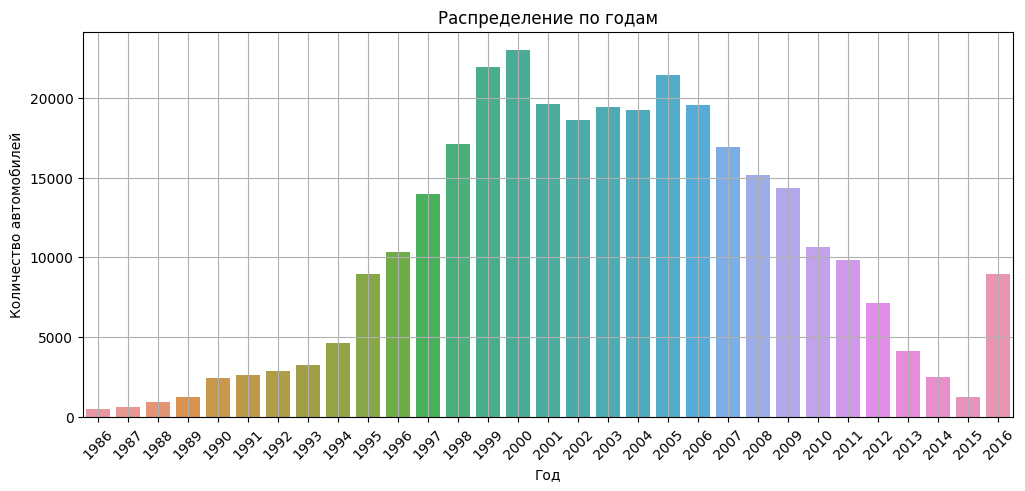

In [28]:
plt.figure(figsize=(12, 5))
bar(data, 'registrationyear', 'Распределение по годам', 'Год')

Год регистрации распределен близко к нормальному, но с большим количеством новых автомобилей, которым менее года.

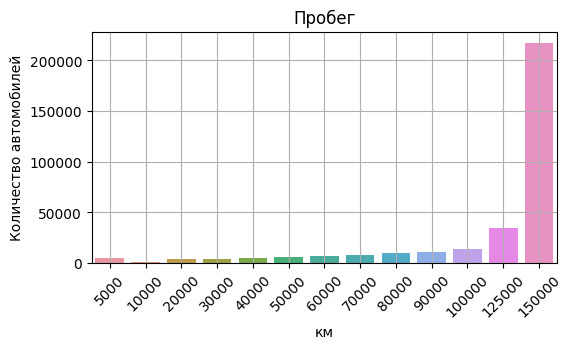

In [29]:
plt.figure(figsize=(6, 3))
bar(data, 'kilometer', 'Пробег', 'км')

Как было видно из описания, почти все автомобили, для которых указан пробег, имеют его значение более 150000 км

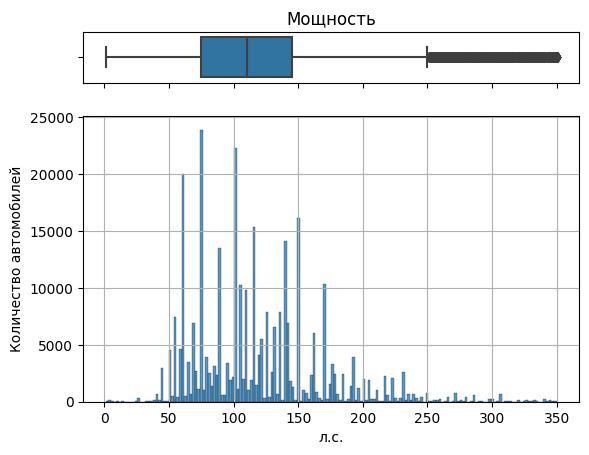

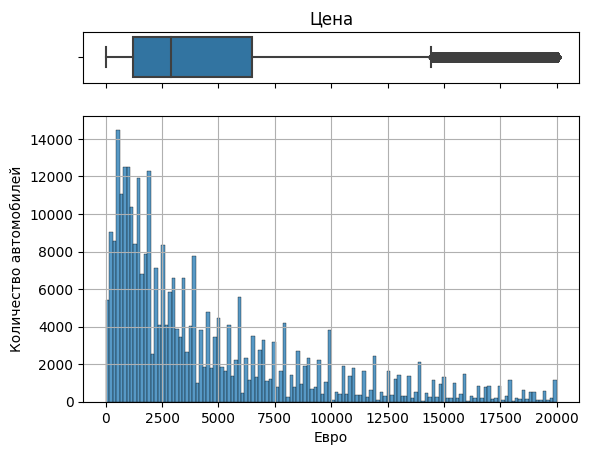

In [30]:
dia_hist_box(data, 'power', 'Мощность', 'л.с.')
dia_hist_box(data, 'price', 'Цена', 'Евро')

У мощности и целевого признака имеются выбросы в большую сторону. По возможности стоит использовать робастные инструменты

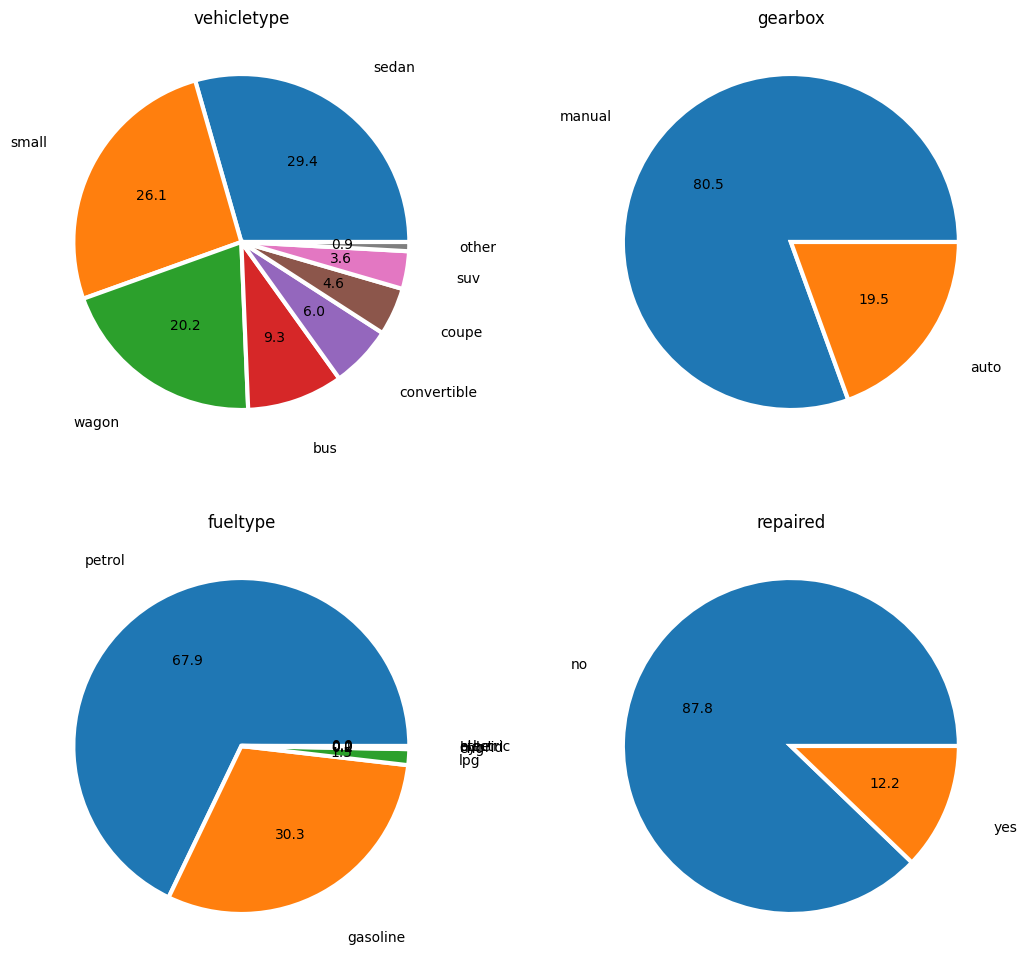

In [31]:
col = ['vehicletype', 'gearbox', 'fueltype', 'repaired']
plt.figure(figsize=(13, 12))
for i in range(0, len(col)):
           plt.subplot(2, 2, (i+1))
           pie(data, col[i])               
plt.legend=True
plt.show()   

In [32]:
data['fueltype'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [33]:
len(data['name'].unique())

334

Признаки ремонта и типа коробки передач являются бинарными, с дисбалансом. Среди указаных типов топлива преобладают два, остальные составляют всего 2%. Среди указанных типов кузова 8 несбалансированных категорий. 

В признаке с моделью автомобиля 334 небольшие категории, стоит это учесть при кодировании признаков

In [34]:
print(data.shape[0] / old_shape)

0.9117378973657105


В результате предобработки было удалено примерно 9% аномальных и некорректных данных. В некоторых признаках имеются выбросы и дисбаланс классов. Один категориальный признак имеет большое число уникальных категорий

### Корреляционный анализ

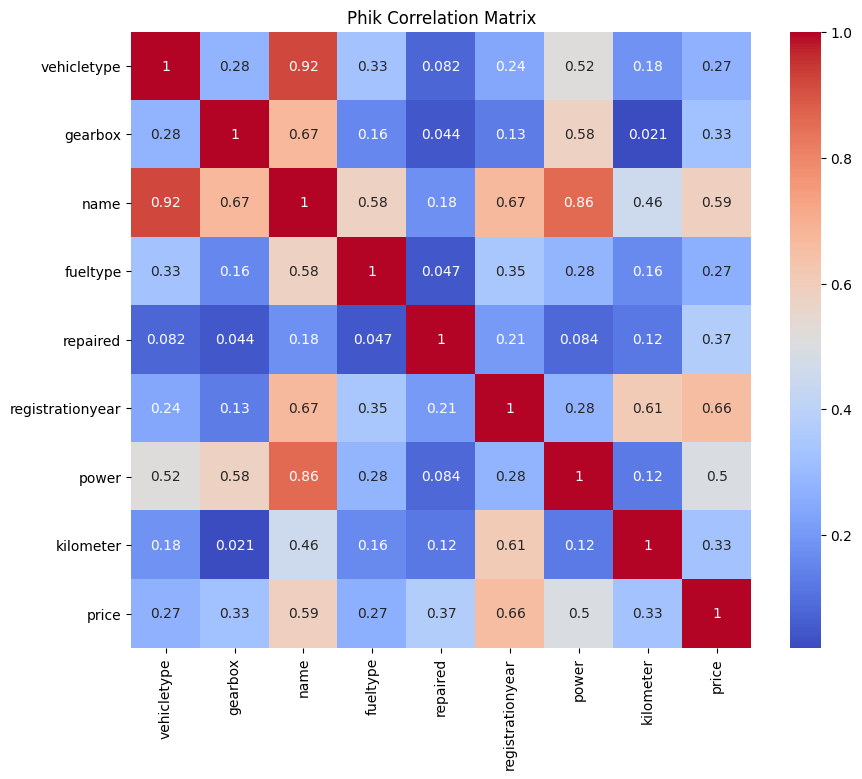

In [35]:
corr_matrix = data.phik_matrix(
    interval_cols=['price', 'power'] 
)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show()

Марка автомобиля имеет высокую корреляцию с типом кузова и мощностью. Цена коррелирует с остальными признаками средне или слабо

## Обучение моделей

Рассмотрим количество уникальных категорий в категориальных признаках

In [36]:
n_unique_categories  = data[cat_col_names].nunique()
n_unique_categories 

vehicletype      8
gearbox          2
name           334
fueltype         7
repaired         2
dtype: int64

В названии марки автомобиля очень много уникальных категорий, что в сочетании с OneHotEncoder может негативно сказаться как на времени работы моделей, так и на результате из-за переобучения. Разделим признаки по количеству уникальных категорий равному 20 и попробуем разные варианты кодирования при подборе моделей.

In [37]:
ohe_col_names = n_unique_categories[n_unique_categories <=20 ].index.tolist()
targ_col_names = n_unique_categories[n_unique_categories > 20].index.tolist()
print(ohe_col_names)
targ_col_names

['vehicletype', 'gearbox', 'fueltype', 'repaired']


['name']

Изменим тип данных категориальных признаков для использования в модели LightGBM

In [38]:
for c in cat_col_names:
    data[c] = data[c].astype('category')
data.dtypes

vehicletype         category
gearbox             category
name                category
fueltype            category
repaired            category
registrationyear       int64
power                float64
kilometer              int64
price                  int64
dtype: object

Разделим датасет на обучающую и тестовую выборки

In [39]:
X = data[num_col_names + cat_col_names]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242316, 8)

(80772, 8)

(242316,)

(80772,)

Создадим пайплайн:
- Пропуски в числовых признаках заменим медианой, а в категориальных - заглушкой.
- Для категориальных признаков будем использовать OHE и TargetEncoder.
- Создадим три разных трансформера для различной обработки категориальных признаков: только OHE, только TargetEncoder, комбинация двух энкодеров

In [40]:
estimator=LinearRegression()
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale',StandardScaler())
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('one-hot',OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

targ_pipeline = Pipeline(steps=[
    ('TargetEncoder',TargetEncoder(target_type='continuous'))
])

col_trans_mix = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_col_names),
    ('ohe_pipeline',ohe_pipeline,ohe_col_names), 
    ('targ_pipeline',targ_pipeline,targ_col_names)
    ],
    remainder='passthrough',
    n_jobs=-1)
col_trans_mix.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['registrationyear', 'power', 'kilometer']),
                                ('ohe_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('one-hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['vehicletype', 'gearbox', 'fueltype',
                                  'repaired']),
                                ('targ_pipeline',
                                 Pipeline(steps=[('TargetEncoder',
                                                  TargetEncoder(target_type='continuous'))]),
                                 ['name'])])

In [41]:
col_trans_ohe = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_col_names),
    ('ohe_pipeline',ohe_pipeline,cat_col_names)
    ],
    remainder='passthrough',
    n_jobs=-1)
col_trans_ohe.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['registrationyear', 'power', 'kilometer']),
                                ('ohe_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('one-hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['vehicletype', 'gearbox', 'name', 'fueltype',
                                  'repaired'])])

In [42]:
col_trans_targ = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_col_names),
    ('targ_pipeline',targ_pipeline,cat_col_names)
    ],
    remainder='passthrough',
    n_jobs=-1)
col_trans_targ.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['registrationyear', 'power', 'kilometer']),
                                ('targ_pipeline',
                                 Pipeline(steps=[('TargetEncoder',
                                                  TargetEncoder(target_type='continuous'))]),
                                 ['vehicletype', 'gearbox', 'name', 'fueltype',
                                  'repaired'])])

Создадим функции. Одна для сравнения метрики и затраченного времени модели с разными кодировщиками. Другая для получения искомых значений. Будем оценивать результаты для базовой модели и если нужно подбирать гиперпараметры 

In [43]:
def test (estimator):
    #Создаём пайплайны с разными трансформерами
    mix = Pipeline(steps=[
            ('col_trans_mix', col_trans_mix),
            ('model', estimator)
        ])
    ohe = Pipeline(steps=[
            ('col_trans_ohe', col_trans_ohe),
            ('model', estimator)
        ])
    targ = Pipeline(steps=[
            ('col_trans_targ', col_trans_targ),
            ('model', estimator)
        ])
    pipelines = [mix, ohe, targ]
    i=0
    names = ['mix', 'ohe', 'targ']
    #Перебираем пайплайны циклом для заданной модели, 
    #выводим время и метрику
    for pipe in pipelines: 
        print(names[i])
        i+=1
        cv_results = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=3, 
            scoring='neg_root_mean_squared_error'
        )
        print('Время обучения:', cv_results['fit_time'].mean())
        print('Время предсказания:', cv_results['score_time'].mean())
        print(
            'RMSE на тестовых данных:', 
             cv_results['test_score'].mean()
        )

In [44]:
def result (estimator, transformer=False):
    #Если нужно создаем пайплайн с трансформером и моделью
    if transformer != False:
        pipe = Pipeline(steps=[
            ('transformer', transformer),
            ('model', estimator)
        ])
    #Или используем модель без трансформера
    else:
        pipe = estimator
    #Возвращаем время обучения, предсказания и RMSE
    cv_results = cross_validate(
        pipe,
        X_train, 
        y_train, 
        cv=3, 
        scoring='neg_root_mean_squared_error'
    )
    learn_time = cv_results['fit_time'].mean()
    pred_time =  cv_results['score_time'].mean()
    pred = cv_results['test_score'].mean()
    return learn_time, pred_time, pred

Начнем с обычной линейной регрессии. Если другие модели покажут себя хуже, не будем их даже рассматривать

In [45]:
test(LinearRegression())

mix
Время обучения: 0.6997876167297363
Время предсказания: 0.41582830746968585
RMSE на тестовых данных: -2600.8563927226346
ohe
Время обучения: 5.811546643575032
Время предсказания: 1.335587739944458
RMSE на тестовых данных: -2479.725702358717
targ
Время обучения: 0.48474876085917157
Время предсказания: 0.27419646581013996
RMSE на тестовых данных: -2628.694891622299


По метрике прошла только модель с OHE, хотя её время обучения в десятки раз больше. Возьмем её показатели

In [46]:
linreg_learntime, linreg_predtime, linreg_pred = result(LinearRegression(), col_trans_ohe)

Рассмотрим дерево решений с базовыми параметрами

In [47]:
test(DecisionTreeRegressor(random_state=RANDOM_STATE))

mix
Время обучения: 1.2962639331817627
Время предсказания: 0.34048938751220703
RMSE на тестовых данных: -2108.319647026553
ohe
Время обучения: 6.691746791203816
Время предсказания: 1.2518273989359539
RMSE на тестовых данных: -1885.7396259438274
targ
Время обучения: 1.233579397201538
Время предсказания: 0.30460460980733234
RMSE на тестовых данных: -2110.136222476351


При использовании только TargetEncoder модель при незначительном ухудшении метрики показывает значительное ускорение вычислений. Переберем некоторые параметры чтобы улучшить качество предсказания

In [48]:
parameters_tree = {'max_depth': range(10, 81, 10), 
              'max_features': range(2, 30), 
             'min_samples_leaf': range(3, 15,)}

In [49]:
rand_search_tree = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE), 
    parameters_tree, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, 
    n_iter=20, 
    random_state=RANDOM_STATE, 
    cv=3
)
rand_search_tree.fit(col_trans_targ.fit_transform(X_train, y_train), y_train)
print('Лучшая модель и её параметры:\n', rand_search_tree.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rand_search_tree.best_score_)

Лучшая модель и её параметры:
 DecisionTreeRegressor(max_depth=20, max_features=12, min_samples_leaf=13,
                      random_state=42)
Метрика лучшей модели на кросс-валидации: -1806.2272119436882


In [50]:
tree_learntime, tree_predtime, tree_pred = result(rand_search_tree.best_estimator_, col_trans_mix)

Получим из результатов рандом серча лучшие параметры по времени, а не по метрике

In [51]:
results=pd.DataFrame(rand_search_tree.cv_results_)
results['time'] = results['mean_fit_time'] + results['mean_score_time']
results = results[[
    'time', 'mean_fit_time', 'mean_score_time', 'params', 'mean_test_score'
]].sort_values(by='time').reset_index(drop=True)
results

,time,mean_fit_time,mean_score_time,params,mean_test_score
0,0.477006,0.419672,0.057334,"{'min_samples_leaf': 8, 'max_features': 2, 'ma...",-1912.735644
1,0.820479,0.800813,0.019666,"{'min_samples_leaf': 13, 'max_features': 12, '...",-1893.962697
2,0.874295,0.828742,0.045553,"{'min_samples_leaf': 6, 'max_features': 5, 'ma...",-1858.039139
3,0.878959,0.863929,0.015030,"{'min_samples_leaf': 9, 'max_features': 29, 'm...",-1895.299591
4,0.930361,0.909698,0.020663,"{'min_samples_leaf': 11, 'max_features': 27, '...",-1811.109317
5,0.989025,0.964358,0.024668,"{'min_samples_leaf': 10, 'max_features': 25, '...",-1814.218353
6,1.081056,1.051715,0.029341,"{'min_samples_leaf': 6, 'max_features': 19, 'm...",-1850.667074
7,1.085170,1.049755,0.035415,"{'min_samples_leaf': 12, 'max_features': 8, 'm...",-1808.281522
8,1.120732,1.089935,0.030797,"{'min_samples_leaf': 13, 'max_features': 25, '...",-1806.876457
9,1.131825,1.081103,0.050723,"{'min_samples_leaf': 13, 'max_features': 12, '...",-1806.227212


In [52]:
params = results['params'][0]
params

{'min_samples_leaf': 8, 'max_features': 2, 'max_depth': 60}

In [53]:
tree_learntime_2, tree_predtime_2, tree_pred_2 = result(
    DecisionTreeRegressor(
        **params,
        random_state=RANDOM_STATE
    ), col_trans_mix)

Далее рассмотрим метод ближайших соседей

In [54]:
test(KNeighborsRegressor())

mix
Время обучения: 0.5921514828999838
Время предсказания: 11.779135465621948
RMSE на тестовых данных: -2649.3313400203074
ohe
Время обучения: 2.503581921259562
Время предсказания: 53.43381651242574
RMSE на тестовых данных: -1730.7791567430604
targ
Время обучения: 1.0324947834014893
Время предсказания: 4.482097625732422
RMSE на тестовых данных: -2693.5578520876547


Модель достигла искомого значения метрики только с OHE, затратив очень много времени. Такие результаты значительно хуже чем у других моделей, поэтому не будем сохранять эти результаты.

Следом рассмотрим рандомный лес. Для ускорения уменьшим максимальную глубину и количество деревьев

In [55]:
test(RandomForestRegressor(random_state=RANDOM_STATE, max_depth=10, n_estimators=50))

mix
Время обучения: 13.547524770100912
Время предсказания: 0.5985522270202637
RMSE на тестовых данных: -1812.075981426218
ohe
Время обучения: 75.75982705752055
Время предсказания: 1.598491907119751
RMSE на тестовых данных: -1878.6524957503307
targ
Время обучения: 11.640830834706625
Время предсказания: 0.5535403887430826
RMSE на тестовых данных: -1802.0757390268375


Модель показала неплохие метрики, однако очень долго обучалась и показала себя не лучше отдельного дерева. Дальнейший перебор параметров либо увеличит время, либо ухудшит метрику, поэтому не будем их подбирать. Сохраним лучший по всем показателям результат с текущими параметрами модели

In [56]:
rf_learntime, rf_predtime, rf_pred = result(
    RandomForestRegressor(random_state=RANDOM_STATE, max_depth=10, n_estimators=50), 
    col_trans_targ
)

Далее рассмотрим градиентный бустинг. В него встроен кодировщик, поэтому можно сразу начинать перебор параметров, обучая на "сырых" данных. Сразу сохраним результат лучшей модели

In [57]:
parameters_lgb = {'num_leaves': range(20, 40, 2), 
              'learning_rate': np.arange(0.01, 0.9, 0.03)}

In [58]:
rand_search_lgb = RandomizedSearchCV(
    lgb.LGBMRegressor(
        random_state=RANDOM_STATE, 
        verbosity=-1
    ), 
    parameters_lgb, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, 
    n_iter=20, 
    random_state=RANDOM_STATE,
    cv=3
)
rand_search_lgb.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n', rand_search_lgb.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rand_search_lgb.best_score_)

Лучшая модель и её параметры:
 LGBMRegressor(learning_rate=0.31, num_leaves=38, random_state=42, verbosity=-1)
Метрика лучшей модели на кросс-валидации: -1566.4848977492336


In [59]:
lgb_learntime, lgb_predtime, lgb_pred = result(rand_search_lgb.best_estimator_)

Аналогично с деревом выбираем лучшие параметры по времени.

In [60]:
results=pd.DataFrame(rand_search_lgb.cv_results_)
results['time'] = results['mean_fit_time'] + results['mean_score_time']
results = results[[
    'time', 'mean_fit_time', 'mean_score_time', 'params', 'mean_test_score'
]].sort_values(by='time').reset_index(drop=True)
results

,time,mean_fit_time,mean_score_time,params,mean_test_score
0,2.209208,2.042276,0.166933,"{'num_leaves': 26, 'learning_rate': 0.7}",-1618.859460
1,2.301723,2.144270,0.157453,"{'num_leaves': 30, 'learning_rate': 0.49}",-1589.614264
2,2.534263,2.357715,0.176548,"{'num_leaves': 26, 'learning_rate': 0.61}",-1610.820332
3,2.619202,2.456838,0.162364,"{'num_leaves': 22, 'learning_rate': 0.66999999...",-1616.761751
4,2.625295,2.478976,0.146319,"{'num_leaves': 22, 'learning_rate': 0.64}",-1614.530013
5,2.748348,2.624109,0.124239,"{'num_leaves': 30, 'learning_rate': 0.52}",-1592.360659
6,2.820421,2.555573,0.264848,"{'num_leaves': 38, 'learning_rate': 0.31}",-1566.484898
7,2.935338,2.802994,0.132344,"{'num_leaves': 24, 'learning_rate': 0.45999999...",-1588.725275
8,2.939615,2.807722,0.131893,"{'num_leaves': 36, 'learning_rate': 0.43}",-1578.410803
9,2.971959,2.851456,0.120502,"{'num_leaves': 32, 'learning_rate': 0.66999999...",-1616.200747


In [61]:
params = results['params'][0]
params

{'num_leaves': 26, 'learning_rate': 0.7}

In [62]:
lgb_learntime_2, lgb_predtime_2, lgb_pred_2 = result(
    lgb.LGBMRegressor(
        **params,
        random_state=RANDOM_STATE, 
        verbosity=-1
    ))

## Анализ моделей

Построим графики и таблицу для сравнения разных моделей, добавив суммарное время на обучение и предсказания

In [63]:
df = {
    'model': ['linear', 'tree', 'tree+', 'rf', 'lgb', 'lgb+'],
    'prediction': [linreg_pred, tree_pred, tree_pred_2, rf_pred, lgb_pred, lgb_pred_2],
    'pred_time': [linreg_predtime, tree_predtime, tree_predtime_2, rf_predtime, lgb_predtime, lgb_predtime_2],
    'learn_time': [linreg_learntime, tree_learntime, tree_learntime_2, rf_learntime, lgb_learntime, lgb_learntime_2]
}
models = pd.DataFrame(df)
models['sum_time'] = models['pred_time'] + models['learn_time']
models['prediction'] = models['prediction'] * -1

In [64]:
def dia_bar(col, name, ytitle):
    sns.barplot(x='model', data=models, y=col)
    plt.title(name)
    plt.ylabel(ytitle)
    plt.xlabel('Модель')
    plt.grid(True) 

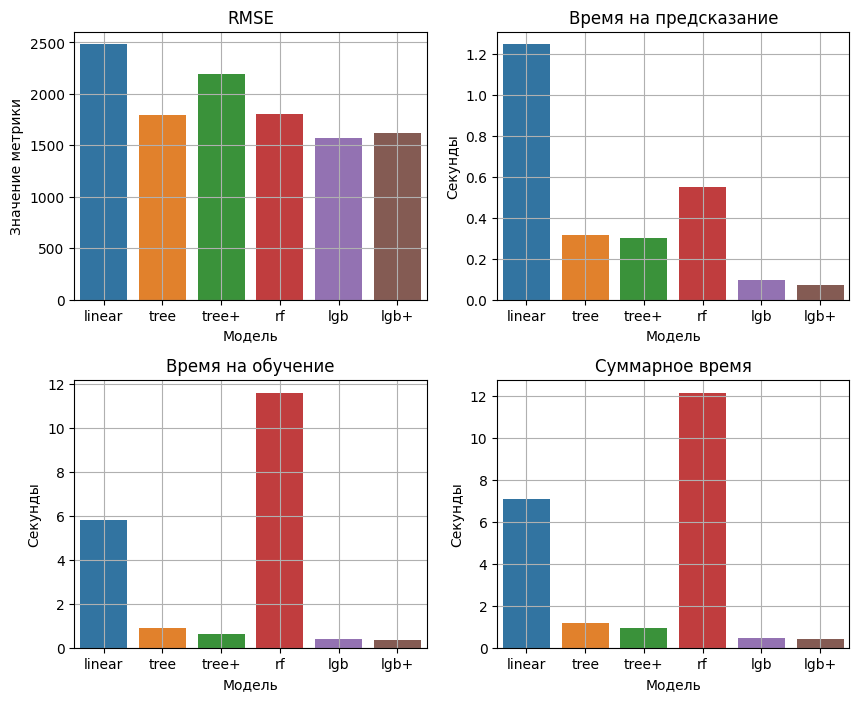

,model,prediction,pred_time,learn_time,sum_time
0,linear,2479.725702,1.245162,5.842551,7.087713
1,tree,1797.897390,0.316887,0.886485,1.203372
2,tree+,2194.066096,0.301169,0.645813,0.946982
3,rf,1802.509057,0.549910,11.622794,12.172704
4,lgb,1566.484898,0.093088,0.376906,0.469994
5,lgb+,1618.859460,0.068999,0.338758,0.407758


In [65]:
col = ['prediction', 'pred_time', 'learn_time', 'sum_time']
name = ['RMSE', 'Время на предсказание', 'Время на обучение', 'Суммарное время']
y = ['Значение метрики', 'Секунды', 'Секунды', 'Секунды']
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
for i in range(0, len(col)):
           plt.subplot(2, 2, (i+1))
           dia_bar(col[i], name[i], y[i])
plt.show() 
display(models)

Наилучшим образом по значению метрики выглядит градиентный бустинг, чуть хуже примерно на одном уровне находятся рандомный лес и дерево решений. По затраченому времени отдельное дерево лидирует, с разницей в десятые доли секунды следом идёт градиентный бустинг. Остальные модели показали себя значительно хуже.
**Для быстрых и точных предсказаний следует взять модель градиентного бустинга, если важнее точность, либо дерево решений, если важнее скорость предсказания**
Для дальнейшего улучшения модели вне зависимости от выбора следует собирать больше данных, особенно про дорогие автомобили, информации о которых было мало в предоставленных данных. Кроме того, следует обратить внимание на сбор информации о годе регистрации, в котором встречались невозможные значения

## Финальный вывод

**Предобработка данных**
Для обучения моделей предсказания цены автомобиля были получены исторические данные о продажах за 2014-2016 год, всего 354368 записей. В результате предобработки были исключены бесполезные признаки, создан новый признак на основе существующих. Были исправлены названия столбцов и удалены дубликаты

**Исследовательский анализ**
В результате исследовательского анализа были обнаружены и удалены 7% некорректных и аномальных данных. Кроме того, были обнаружены данные с выбросами, дисбалансом и один признак с большим количеством уникальных категорий

**Корреляционный анализ**
Целевой признак средне или слабо коррелирует с другими, мультиколлинеарность отсутствует

**Обучение моделей**
Для выбора оптимальной модели были протестированы несколько вариантов кодирования данных, по возможности подобраны гиперпараметры. Рассмотрены такие модели как линейная регрессия, дерево решений, метод ближайших соседей, случайный лес и градиентный бустинг, получены метрики и время обучения для сравнения. Метод ближайших соседей показал себя хуже базовой линейной модели, поэтому был исключен из рассмотрения.

**Анализ моделей и рекомендации**
Лучше всего себя показали градиентный бустинг и дерево решений. В первом случае была выше точность, во втором - незначительно выше скорость. Для дальнейшего улучшения модели стоит собирать больше данных, особенно о дорогих автомобилях, а также следить за чистотой и качеством сбора данных